In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("/n/home13/wcarvalho/projects/marl")
print("at directory:", os.getcwd())

at directory: /n/home13/wcarvalho/results/jaxrl_results
changing to root directory
at directory: /n/home13/wcarvalho/projects/marl


In [3]:
# ACTUAL RUNS
# !ls baselines/save_data
# !ls trainer_v1/dynaq/save_data
# !ls "trainer_v1/dynaq/save_data/dyna-coeff-8-i5/alg=dynaq,DYNA=1.0,TRAI=5,TEMP=0.25,TEMP=0.5/"
# !ls "trainer_v1/dynaq/save_data/dyna-coeff-8-i5/alg=dynaq,DYNA=1.0,TRAI=5,TEMP=0.25,TEMP=0.5/"
# !ls trainer_v1/dynaq/save_data/*/*

In [4]:
# DUMMY RUNS
!ls /n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/ql/save_data/*/*/qlearning.safetensors

'/n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/ql/save_data/qlearning-4/alg=qlearning,TOTA=30000000.0/qlearning.safetensors'
'/n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/ql/save_data/qlearning-5/alg=qlearning,SAMP=5,BUFF=256,TOTA=30000000.0/qlearning.safetensors'


In [5]:
!ls /n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/dynaq/save_data/*/*/

'/n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/dynaq/save_data/dynaq-11-extra/alg=dynaq,TOTA=5000000.0,SIM_=gamma,DYNA=0.0,DYNA=0.1/':
dynaq_23.safetensors  dynaq_26.safetensors  dynaq.safetensors
dynaq_24.safetensors  dynaq_27.safetensors
dynaq_25.safetensors  dynaq.config

'/n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/dynaq/save_data/dynaq-6-policy/alg=dynaq,SAMP=5,BUFF=256,TOTA=7500000.0,SIM_=gamma,NUM_=15/':
dynaq.safetensors

'/n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/dynaq/save_data/dynaq-6-policy/alg=dynaq,TOTA=7500000.0,SIM_=epsilon/':

'/n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/dynaq/save_data/dynaq-7-policy/alg=dynaq,SAMP=5,BUFF=256,TOTA=7500000.0,SIM_=gamma,NUM_=15/':
dynaq.config  dynaq.safetensors

'/n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/dynaq/save_data/dynaq-8-extra/alg=dynaq,TOTA=30000000.0,SIM_=gamma,DYNA=0.0,DYNA=0.0/':
dynaq_22.safetensors  dynaq_23

In [6]:
from safetensors.flax import load_file
from flax.traverse_util import unflatten_dict
import pickle

def load_params(filename):
    flattened_dict = load_file(filename)
    return unflatten_dict(flattened_dict, sep=',')

def load_params_config(path: str, file: str, config=True):
    params = load_params(f'{path}/{file}.safetensors')

    if config:
        with open(f'{path}/{file}.config', 'rb') as f:
            config = pickle.load(f)
    return params, config

# Setup Environment

In [7]:
import jax
import jax.numpy as jnp
import functools

import projects.humansf.trainer_housemaze as trainer
from projects.humansf import housemaze_env as maze
from projects.humansf.housemaze import utils
from projects.humansf.housemaze import renderer

/n/home13/wcarvalho/.conda/envs/jaxneurorl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-14 17:16:07,163	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-14 17:16:10,819	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/n/home13/wcarvalho/.local/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:145: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/goo

In [ ]:
group_set, env_params = trainer.load_env_params(
    num_groups=3,
    file='projects/humansf/housemaze_list_of_groups.npy',
    large_only=True,
)
image_dict = utils.load_image_dict('projects/humansf/housemaze/image_data.pkl')

env_params = env_params.replace(
    # p_test_sample_train=0.,
    training=False)

task_objects = group_set.reshape(-1)
task_objects

In [9]:
jax.tree_map(lambda x:jnp.asarray(x).shape, env_params)

EnvParams(reset_params=ResetParams(map_init=MapInit(grid=(1, 13, 13, 1), agent_pos=(1, 2), agent_dir=(1,)), train_objects=(1, 3), test_objects=(1, 3), starting_locs=(1, 3, 10, 2), curriculum=(1,)), time_limit=(), p_test_sample_train=(), training=())

In [10]:
seed = 6
rng = jax.random.PRNGKey(seed)

task_runner = maze.TaskRunner(
    task_objects=task_objects)
env = maze.HouseMaze(
    task_runner=task_runner,
    num_categories=len(image_dict['keys']),
)
env = utils.AutoResetWrapper(env)


In [69]:
# num_parallel_envs = 100
train_objects = env_params.reset_params.train_objects[0, :2]
test_objects = env_params.reset_params.test_objects[0, :2]
train_objects, test_objects

(Array([26, 47], dtype=int32), Array([40, 43], dtype=int32))

In [12]:
num_envs = 25
def vmap_reset(rng, env_params):
    return jax.vmap(env.reset, in_axes=(0, None))(jax.random.split(rng, num_envs), env_params)

def vmap_step(rng, env_state, action, env_params):
    return jax.vmap(env.step, in_axes=(0, 0, 0, None))(jax.random.split(rng, num_envs), env_state, action, env_params)

rng, rng_ = jax.random.split(rng)
init_timestep = vmap_reset(rng=rng_, env_params=env_params)

# Load agents

In [13]:
from projects.humansf import networks
from agents import value_based_basics as vbb

### Q-learning

In [6]:
x = '4'
y = x
variable_name = [name for name, value in locals().items() if value is y][0]
variable_name

'x'

In [14]:
# DUMMY RUNS
!ls /n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/ql/save_data/*/*/qlearning.safetensors

'/n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/ql/save_data/qlearning-4/alg=qlearning,TOTA=30000000.0/qlearning.safetensors'
'/n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/ql/save_data/qlearning-5/alg=qlearning,SAMP=5,BUFF=256,TOTA=30000000.0/qlearning.safetensors'


In [41]:
# REAL RUNS
!ls /n/home13/wcarvalho/results/jaxrl_results/trainer_housemaze/ql/save_data/*/*/qlearning.safetensors

'/n/home13/wcarvalho/results/jaxrl_results/trainer_housemaze/ql/save_data/qlearning-5/alg=qlearning,SAMP=10,BUFF=128,TOTA=30000000.0/qlearning.safetensors'
'/n/home13/wcarvalho/results/jaxrl_results/trainer_housemaze/ql/save_data/qlearning-5/alg=qlearning,SAMP=20,BUFF=64,TOTA=30000000.0/qlearning.safetensors'
'/n/home13/wcarvalho/results/jaxrl_results/trainer_housemaze/ql/save_data/qlearning-5/alg=qlearning,SAMP=40,BUFF=32,TOTA=30000000.0/qlearning.safetensors'
'/n/home13/wcarvalho/results/jaxrl_results/trainer_housemaze/ql/save_data/qlearning-5/alg=qlearning,SAMP=5,BUFF=256,TOTA=30000000.0/qlearning.safetensors'


In [43]:
dummq_q_dir = '/n/home13/wcarvalho/results/jaxrl_results/trainer_housemaze/ql/save_data/qlearning-5/alg=qlearning,SAMP=40,BUFF=32,TOTA=30000000.0/'
q_params, q_config = load_params_config(dummq_q_dir, 'qlearning')

In [16]:
q_config['NUM_ENVS'] = num_envs

In [17]:
# Q-learning
from projects.humansf import qlearning

make_agent=functools.partial(
    qlearning.make_agent,
    ObsEncoderCls=networks.HouzemazeObsEncoder,
)

rng, rng_ = jax.random.split(rng)
q_agent, _, q_reset_fn = make_agent(
    config=q_config,
    env=env,
    env_params=env_params,
    example_timestep=init_timestep,
    rng=rng_)

q_actor = qlearning.make_actor(
            config=q_config,
            agent=q_agent,
            rng=rng_)

q_train_state = vbb.CustomTrainState.create(
            apply_fn=q_agent.apply,
            params=q_params,
            target_network_params=q_params,
            tx=qlearning.make_optimizer(q_config),  # unnecessary
            timesteps=0,
            n_updates=0,
            n_logs=0,
        )



### Dyna-Q

In [18]:
# Dyna
dummy_dyna_file = '/n/home13/wcarvalho/results/jaxrl_results_single/trainer_housemaze/dynaq/save_data/dynaq-8-extra/alg=dynaq,TOTA=30000000.0,SIM_=gamma,DYNA=0.0,DYNA=0.0/'
dynaq0_params, _ = load_params_config(dummy_dyna_file, 'dynaq_22', config=False)
dynaq50_params, _ = load_params_config(dummy_dyna_file, 'dynaq_23', config=False)
dynaq100_params, dynaq_config = load_params_config(dummy_dyna_file, 'dynaq')

In [19]:
dynaq_config['NUM_ENVS'] = num_envs

In [20]:
from projects.humansf import offtask_dyna

make_agent=functools.partial(
    offtask_dyna.make_agent,
    ObsEncoderCls=networks.HouzemazeObsEncoder,
    model_env_params=env_params)

rng, rng_ = jax.random.split(rng)
dynaq_agent, _, dynaq_reset_fn = make_agent(
    config=dynaq_config,
    env=env,
    env_params=env_params,
    example_timestep=init_timestep,
    rng=rng_)

dynaq_actor = offtask_dyna.make_actor(
            config=dynaq_config,
            agent=dynaq_agent,
            rng=rng_)

dyna_train_states = [
    vbb.CustomTrainState.create(
            apply_fn=dynaq_agent.apply,
            params=params,
            target_network_params=params,
            tx=offtask_dyna.make_optimizer(dynaq_config),  # unnecessary
            timesteps=0,
            n_updates=0,
            n_logs=0,
        )
    for params in [dynaq0_params, dynaq50_params, dynaq100_params]
]



# Collect data

In [21]:
import jax.tree_util as jtu

def swap_task(x: maze.TimeStep, w: jax.Array):
    new_state = x.state.replace(
        step_num=jnp.zeros_like(x.state.step_num),
        task_w=w,
    )

    return x.replace(
        state=new_state,
    )

def collect_trajectory(
    init_timestep,
    task_w,
    rng,
    train_state: vbb.CustomTrainState,
    actor,
    agent_reset_fn,
    max_steps: int = 50,
    ):
    
    rng, rng_ = jax.random.split(rng)
    
    timestep = jax.vmap(swap_task, (0, None))(init_timestep, task_w)
    agent_state = agent_reset_fn(train_state.params, timestep, rng_)

    runner_state = vbb.RunnerState(
        train_state=train_state,
        timestep=timestep,
        agent_state=agent_state,
        rng=rng)

    _, traj_batch = vbb.collect_trajectory(
                runner_state=runner_state,
                num_steps=max_steps,
                actor_step_fn=actor.train_step,
                env_step_fn=vmap_step,
                env_params=env_params)

    return traj_batch

def fix_shape(traj):
    traj = jax.tree_map(lambda x:jnp.swapaxes(x, 1, 2), traj)
    # pprint(jax.tree_map(lambda x:x.shape, traj))
    # traj = jax.tree_map(lambda x:x.reshape(num_envs*len(task_ws), *x.shape[2:]), traj)
    return traj

def collect_trajectories(init_timestep, task_ws, collect_fn, rng, n=4):
    all_trajs = []
    for _ in range(n):
        rng, rng_ = jax.random.split(rng)
        trajs = jax.vmap(collect_fn, (None, 0, 0))(init_timestep, task_ws, jax.random.split(rng_, len(task_ws)))
        all_trajs.append(trajs)
    all_trajs = jtu.tree_map(lambda *v: jnp.concatenate(v, axis=2), *all_trajs)
    all_trajs = fix_shape(all_trajs)
    return all_trajs


In [22]:
q_collect = functools.partial(
    collect_trajectory,
    train_state=q_train_state,
    agent_reset_fn=q_reset_fn,
    actor=q_actor)

task_ws = jnp.array([task_runner.task_vector(o) for o in test_objects])
trajs = []
q_trajs = collect_trajectories(init_timestep, task_ws, q_collect, rng, n=5)
jax.tree_map(lambda x:x.shape, q_trajs)

Transition(timestep=TimeStep(state=EnvState(key=(2, 125, 50, 2), step_num=(2, 125, 50), grid=(2, 125, 50, 13, 13, 1), agent_pos=(2, 125, 50, 2), agent_dir=(2, 125, 50), map_idx=(2, 125, 50), task_w=(2, 125, 50, 6), is_train_task=(2, 125, 50), task_object=(2, 125, 50), offtask_w=(2, 125, 50, 6), task_state=TaskState(features=(2, 125, 50, 6), grid=(2, 125, 50, 13, 13, 1))), step_type=(2, 125, 50), reward=(2, 125, 50), discount=(2, 125, 50), observation=Observation(image=(2, 125, 50, 13, 13, 51), task_w=(2, 125, 50, 6), state_features=(2, 125, 50, 6), position=(2, 125, 50, 26), direction=(2, 125, 50, 4), prev_action=(2, 125, 50, 5))), action=(2, 125, 50), extras=FrozenDict({
    agent_state: ((2, 125, 50, 16), (2, 125, 50, 16)),
    preds: Predictions(q_vals=(2, 125, 50, 4), rnn_states=(2, 125, 50, 16)),
}))

In [61]:
q_trajs.action

Array([[[1, 0, 0, ..., 2, 3, 0],
        [1, 1, 1, ..., 3, 0, 3],
        [0, 3, 1, ..., 1, 1, 0],
        ...,
        [0, 3, 2, ..., 0, 0, 0],
        [2, 0, 3, ..., 0, 0, 0],
        [1, 0, 0, ..., 2, 2, 2]],

       [[1, 1, 2, ..., 0, 0, 1],
        [1, 2, 3, ..., 0, 3, 0],
        [0, 3, 0, ..., 2, 1, 2],
        ...,
        [1, 0, 3, ..., 0, 0, 0],
        [2, 2, 2, ..., 2, 2, 2],
        [1, 2, 2, ..., 0, 0, 1]]], dtype=int32)

In [23]:
dyna_trajs = []
for train_state in dyna_train_states:
    dyna_collect = functools.partial(
        collect_trajectory,
        train_state=train_state,
        agent_reset_fn=dynaq_reset_fn,
        actor=dynaq_actor)

    # dyna_traj = jax.vmap(dyna_collect, (None, 0, 0))(init_timestep, task_ws, jax.random.split(rng, len(task_ws)))
    dyna_traj = collect_trajectories(init_timestep, task_ws, dyna_collect, rng, n=5)
    dyna_trajs.append(dyna_traj)
jax.tree_map(lambda x:x.shape, dyna_trajs[0])

Transition(timestep=TimeStep(state=EnvState(key=(2, 125, 50, 2), step_num=(2, 125, 50), grid=(2, 125, 50, 13, 13, 1), agent_pos=(2, 125, 50, 2), agent_dir=(2, 125, 50), map_idx=(2, 125, 50), task_w=(2, 125, 50, 6), is_train_task=(2, 125, 50), task_object=(2, 125, 50), offtask_w=(2, 125, 50, 6), task_state=TaskState(features=(2, 125, 50, 6), grid=(2, 125, 50, 13, 13, 1))), step_type=(2, 125, 50), reward=(2, 125, 50), discount=(2, 125, 50), observation=Observation(image=(2, 125, 50, 13, 13, 51), task_w=(2, 125, 50, 6), state_features=(2, 125, 50, 6), position=(2, 125, 50, 26), direction=(2, 125, 50, 4), prev_action=(2, 125, 50, 5))), action=(2, 125, 50), extras=FrozenDict({
    agent_state: ((2, 125, 50, 16), (2, 125, 50, 16)),
    preds: Predictions(q_vals=(2, 125, 50, 4), state=AgentState(timestep=TimeStep(state=EnvState(key=(2, 125, 50, 2), step_num=(2, 125, 50), grid=(2, 125, 50, 13, 13, 1), agent_pos=(2, 125, 50, 2), agent_dir=(2, 125, 50), map_idx=(2, 125, 50), task_w=(2, 125, 50, 

In [24]:
print(4)

4


# plots

In [70]:
train_ws = jnp.array([task_runner.task_vector(o) for o in train_objects])
q_train_trajs = collect_trajectories(init_timestep, train_ws, q_collect, rng, n=4)

### visualize trajectory

In [71]:
traj = jax.tree_map(lambda x: x[0,0], q_train_trajs)

In [74]:
train_objects, test_objects

(Array([26, 47], dtype=int32), Array([40, 43], dtype=int32))

In [73]:
traj.timestep.state.task_object

Array([43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43],      dtype=int32)

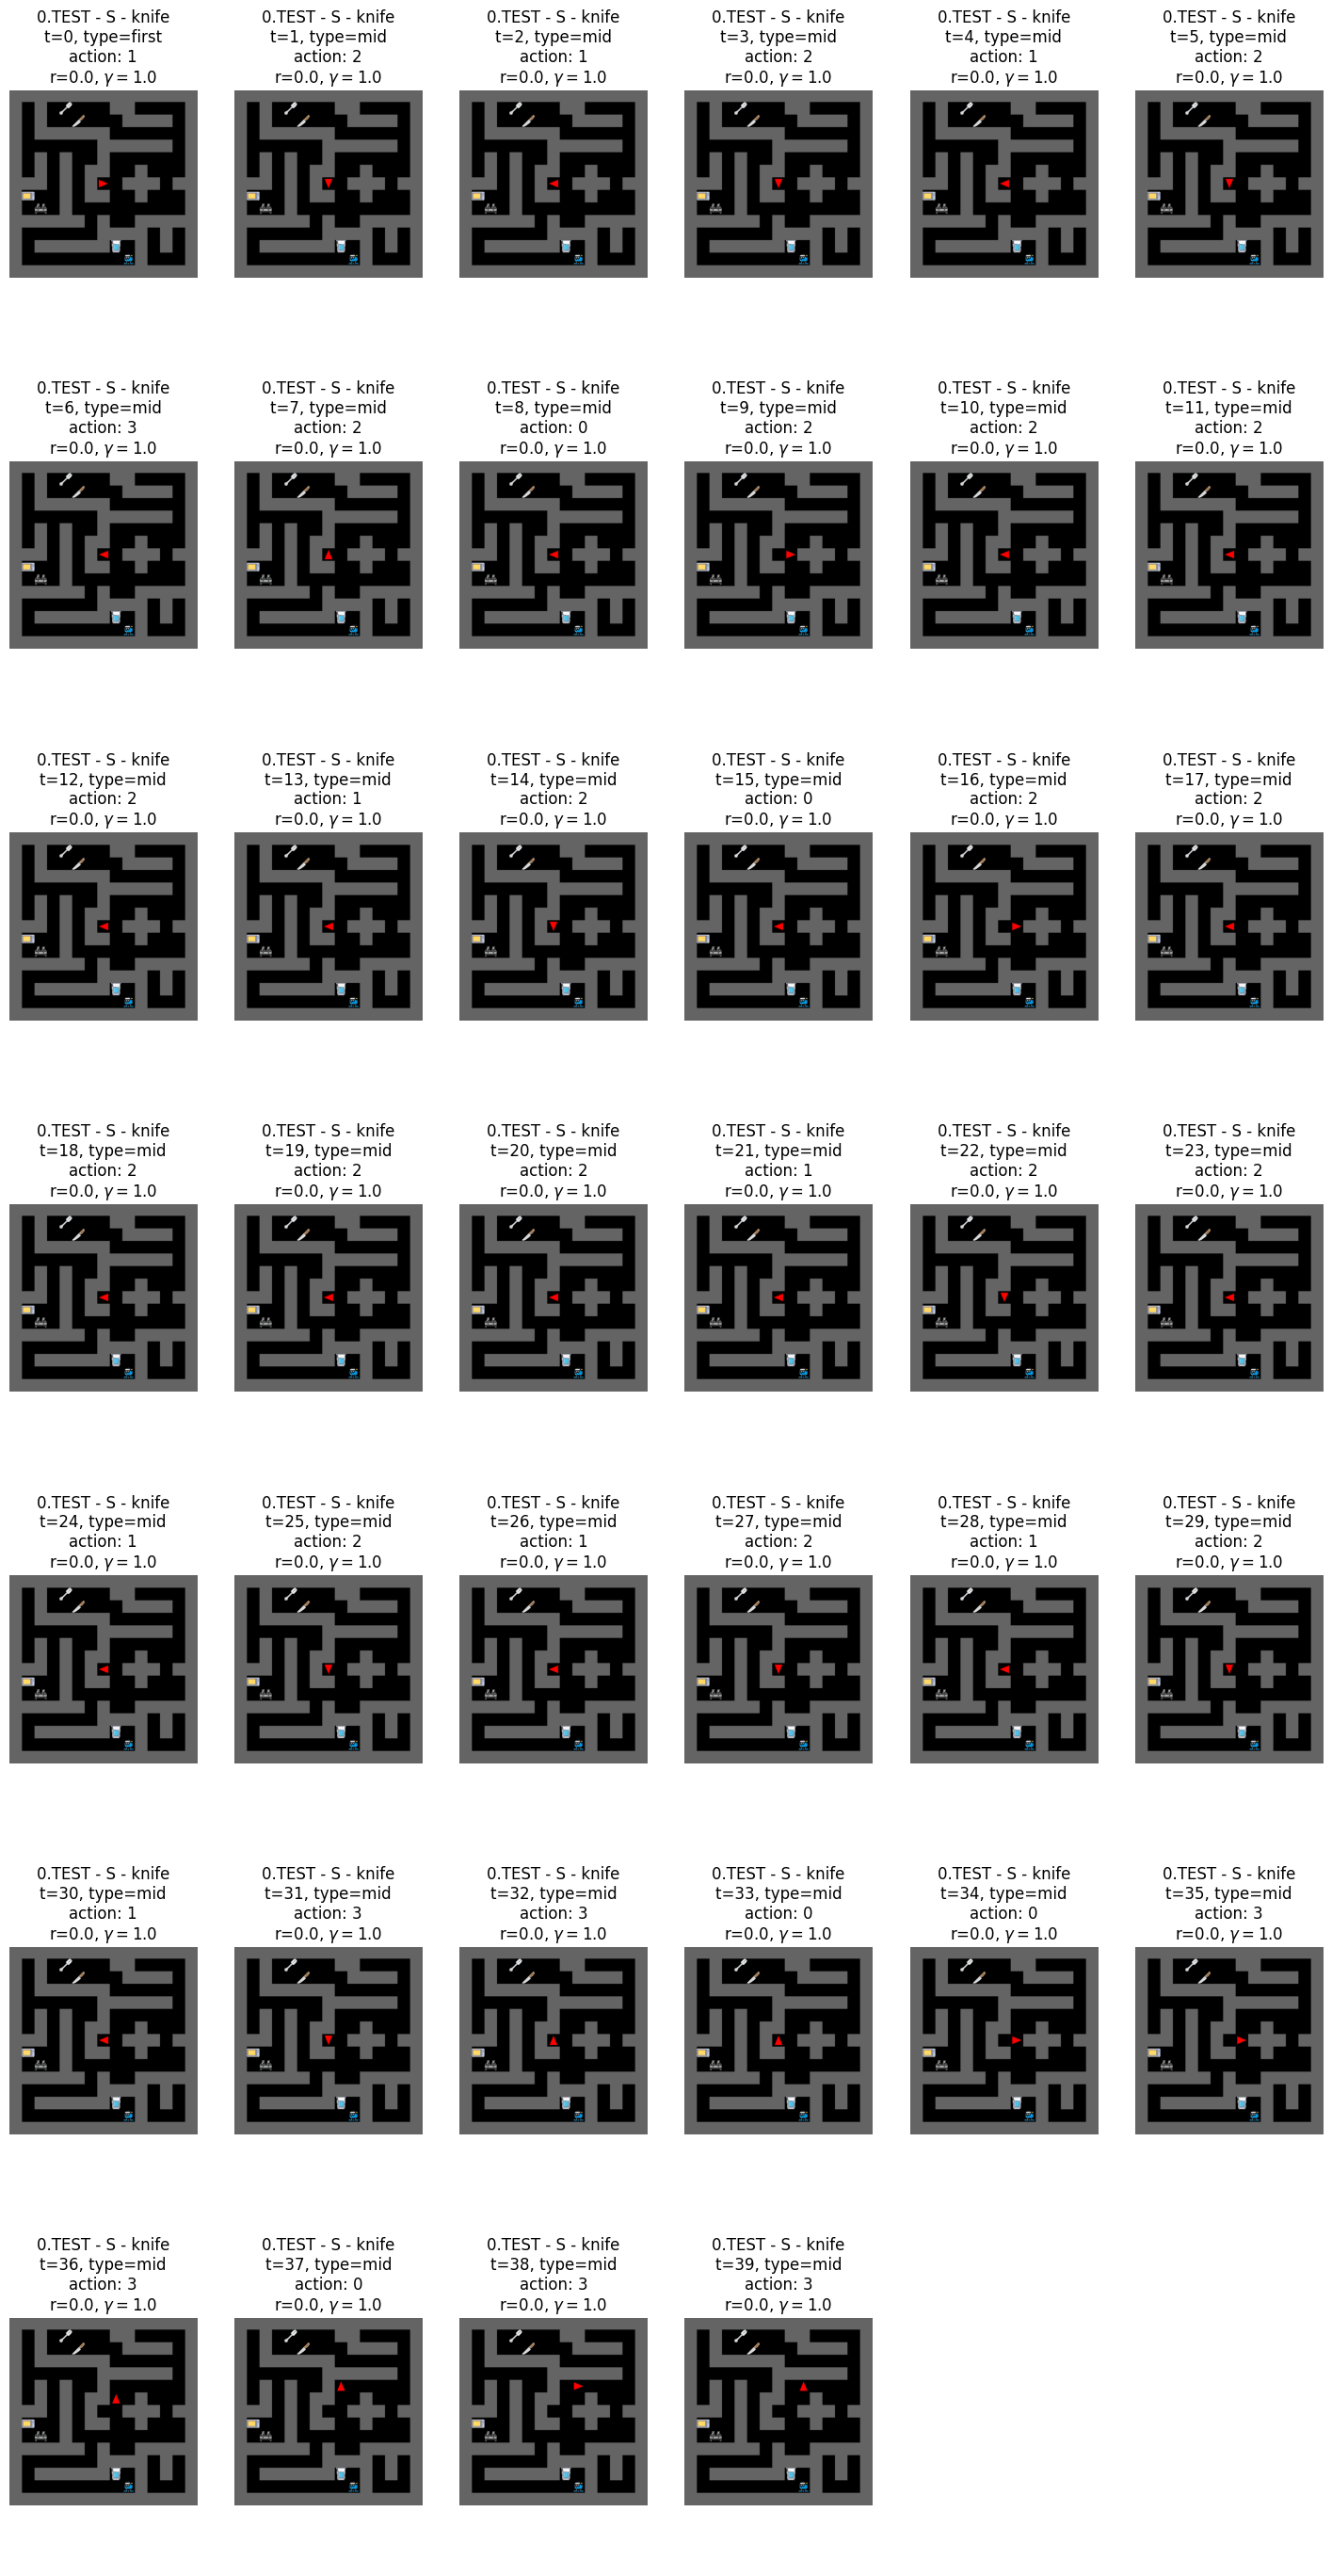

In [72]:
from projects.humansf import visualizer
from projects.humansf.housemaze import utils as housemaze_utils
import matplotlib.pyplot as plt

image_dict = housemaze_utils.load_image_dict('projects/humansf/housemaze/image_data.pkl')
keys = image_dict['keys']
def housemaze_render_fn(state: maze.EnvState):
    return renderer.create_image_from_grid(
        state.grid,
        state.agent_pos,
        state.agent_dir,
        image_dict)
render_fn = housemaze_render_fn
# def plot_timestep_observations(
#         timestep,
#         render_fn,
#         max_len: int = 40,
#         ):

#     obs_images = []
#     for idx in range(max_len):
#         index = lambda y: jax.tree_map(lambda x: x[idx], y)
#         obs_image = render_fn(index(timestep.state))
#         obs_images.append(obs_image)
#     return obs_images
def extract_task_info(timestep: maze.TimeStep):
  state = timestep.state
  return {
      'map_idx': state.map_idx,
      'is_train_task': state.is_train_task,
      'category': state.task_object,
   }

def get_task_name(variables):
  map_idx = variables['map_idx']
  category = keys[variables['category']]
  is_train_task = variables['is_train_task']
  label = '1.train' if is_train_task else '0.TEST'
  setting = 'S' if map_idx == 0 else 'L'

  return f'{label} - {setting} - {category}'

def plot_timesteps(traj, max_len=40, action_names=None):
      timesteps = traj.timestep
      actions = traj.action
      #################
      # frames
      #################
      obs_images = []
      for idx in range(max_len):
          index = lambda y: jax.tree_map(lambda x: x[idx], y)
          obs_image = render_fn(index(timesteps.state))
          obs_images.append(obs_image)

      #################
      # actions
      #################
      def action_name(a):
        if action_names is not None:
          name = action_names.get(int(a), 'ERROR?')
          return f"action {int(a)}: {name}"
        else:
          return f"action: {int(a)}"
      actions_taken = [action_name(a) for a in actions]

      #################
      # plot
      #################
      index = lambda t, idx: jax.tree_map(lambda x: x[idx], t)
      def panel_title_fn(timesteps, i):
        task_name = get_task_name(extract_task_info(index(timesteps, i)))
        title = f'{task_name}'

        step_type = int(timesteps.step_type[i])
        step_type = ['first', 'mid', '|last|'][step_type]
        title += f'\nt={i}, type={step_type}'

        if i < len(actions_taken):
          title += f'\n{actions_taken[i]}'
        title += f'\nr={timesteps.reward[i]}, $\\gamma={timesteps.discount[i]}$'

        return title

      fig = visualizer.plot_frames(
          timesteps=timesteps,
          frames=obs_images,
          panel_title_fn=panel_title_fn,
          ncols=6)


plot_timesteps(traj)
# frames = plot_timestep_observations(traj.timestep, render_fn=housemaze_render_fn)

# grid = visualizer.plot_frames(traj.timestep, frames, ncols=10)
# plt.imshow(grid)

### success rate

In [44]:
def make_float(x): return x.astype(jnp.float32)

def success(traj):
    timesteps = traj.timestep
    rewards = timesteps.reward
    
    # get mask for within episode
    non_terminal = timesteps.discount
    is_last = timesteps.last()
    term_cumsum = jnp.cumsum(is_last, 0)
    in_episode = make_float((term_cumsum + non_terminal) < 2)

    success = make_float((in_episode*rewards).sum() > .5)
    return success

success2 = jax.vmap(jax.vmap(success))
# q_sucesses = success2(q_trajs)
# dyna_end_sucesses = success2(dyna_trajs[-1])



In [48]:
train_ws = jnp.array([task_runner.task_vector(o) for o in train_objects])
q_train_trajs = collect_trajectories(init_timestep, train_ws, q_collect, rng, n=4)
q_train_success = success2(q_train_trajs)
q_train_success.mean(-1)

Array([0., 0.], dtype=float32)